In [1]:
import string
import logging 
from collections import defaultdict
import pandas as pd
from wordcloud import WordCloud
import requests
import matplotlib.pyplot as plt
import re
from dotenv import load_dotenv
import os
import bs4
from konlpy.tag import Mecab
import json
from IPython.display import display
import math
from collections import Counter

logging.basicConfig(level=logging.INFO)
load_dotenv()

mecab = Mecab()
KOREAN_DICT_API_KEY = os.getenv("KOREAN_DICT_API_KEY")
KOREAN_DICT_MAIN_URL = "https://krdict.korean.go.kr/api/search" #50_000 tokens/day

In [2]:
def remove_punctuation(text):
    new_string = text.translate(str.maketrans('', '', string.punctuation))
    return new_string

In [3]:
def remove_special_character(text, character):
    new_string = text.replace(character, '')
    return new_string

In [4]:
def remove_stop_words(text, stop_words):
    text_words = text.split()
    result = [word for word in text_words if word not in stop_words]
    new_text = ' '.join(result)
    return new_text

In [5]:
def remove_non_korean_words(string):
    regex = re.compile("[A-z]+")
    return regex.sub('', string)

In [6]:
def translate_word(word):
    return

In [7]:
def remove_chinese_words(string):
    regex = re.compile("[\u4e00-\u9FFF]")
    return regex.sub('', string)

In [8]:
logging.info("##### LOADING DATA #####")

novels = []
for root, dirs, filenames in os.walk("../data/novels"):
    for filename in filenames:
        with open(os.path.join(root, filename), "r", encoding="utf8") as f:
            novel = {"title":filename, "content":f.readlines()}
            novels.append(novel)
    
with open("../data/korean_texts.txt", "r", encoding="utf8") as file:
    gongu = file.readlines()
    
with open("../data/stop_words.txt", "r", encoding="utf8") as file:
    stop_words = file.readlines()

with open("../data/lyrics.txt", "r", encoding="utf8") as file:
    lyrics = file.readlines()

with open("../POS/mecab.json", "r", encoding="utf8") as file:
    mecab_pos = json.load(file)
with open("../POS/national_institute_korean_language.json", "r", encoding="utf8") as file:
    nikl_pos = json.load(file)

topik_top_words = pd.read_excel("../data/Korean_vocabular_TOPIK.xlsx")

INFO:root:##### LOADING DATA #####


In [9]:
topik_top_words = topik_top_words[["Word","Classification","English"]]
topik_top_words_noun = topik_top_words[topik_top_words["Classification"] == "noun"]
topik_top_words_adjective = topik_top_words[topik_top_words["Classification"] == "adjective"]
topik_top_words_verb = topik_top_words[(topik_top_words["Classification"] == "verb") | (topik_top_words["Classification"] == "auxiliary verb")]
topik_top_words_adverb = topik_top_words[topik_top_words["Classification"] == "adverb"]

In [10]:
topik_top_words_noun.head()

Word Classification               English
0     것           noun  A thing or an object
5     수           noun    way, method, means
11   사람           noun                Person
17    등           noun                  rank
18    때           noun        occasion; time

In [11]:
topik_top_words_adjective.head()

Word Classification                English
3    있다      adjective                  To be
9    없다      adjective   Do not exist, absent
15  아니다      adjective              To not be
21   같다      adjective          To be similar
37  그렇다      adjective  That is right or yes.

In [12]:
topik_top_words_verb.head()

Word  Classification                                     English
1    하다            verb                                       To do
2    있다  auxiliary verb  1. to be (in a place); to exist 2. to have
4    되다            verb   to become; (of a time) to come, to arrive
6    하다  auxiliary verb                                       To do
10   않다  auxiliary verb                                   To not do

In [13]:
topik_top_words_adverb.head()

Word Classification               English
33  그러나         adverb  However or but still
39    또         adverb             also, too
43    안         adverb        ~ not ~ + VERB
45    더         adverb                  More
51  그리고         adverb       And or and then

In [14]:
def clean_text(text,stop_words, name):
    special_characters = ['\xa0', '\n']
    
    text =  [remove_punctuation(string) for string in text]
    
    for character in special_characters:
        text =  [remove_special_character(string, character) for string in text]
        stop_words = [remove_special_character(string, character) for string in stop_words]
    
    text = [remove_stop_words(string, stop_words) for string in text]

    text = [remove_non_korean_words(string) for string in text]

    text = [remove_chinese_words(string) for string in text]

    text = [line for line in text if line != '']
    
    with open(f"../data/cleaned/{name}_cleaned.txt", "w", encoding="utf8") as file:
        print(text, file=file)
    return text

In [15]:
logging.info("##### CLEANING DATA #####")
logging.info("Removing punctuation, special characters, empty lines, stop words.")

for novel in novels:
    novel["content"] = clean_text(novel["content"], stop_words, novel["title"])
gongu = clean_text(gongu, stop_words, "korean_texts")
lyrics = clean_text(lyrics, stop_words, "lyrics")

INFO:root:##### CLEANING DATA #####
INFO:root:Removing punctuation, special characters, empty lines, stop words.


In [16]:
def get_word_frequency(text, pos=None):
    word_dict = defaultdict(int)
    if pos is not None:
        for line in text:
            for word in mecab.pos(line):
                if word[1] == pos:
                    word_dict[word[0]] += 1
    else:
        for line in text:
            for word in mecab.morphs(line):
                word_dict[word] += 1
    
    data = pd.DataFrame(word_dict.items()) \
    .sort_values(1, ascending=False) \
    .rename(columns={0:"word", 1: 'abs_freq'}) \
    .reset_index(drop=True)
    return data

In [17]:
novels_word_frequency = pd.DataFrame(columns=["word", "abs_freq"])
for novel in novels:
    current_frequency = get_word_frequency(novel["content"])
    if novels_word_frequency.empty:
        novels_word_frequency = current_frequency.copy()
    else:
        novels_word_frequency = pd.concat([novels_word_frequency, current_frequency])
        novels_word_frequency = novels_word_frequency.groupby(["word"], as_index=False)["abs_freq"].sum().sort_values("abs_freq", ascending=False).reset_index(drop=True)
articles_word_frequency = get_word_frequency(gongu)
lyrics_word_frequency = get_word_frequency(lyrics)

In [18]:
novels_word_frequency.head()

word  abs_freq
0    는     12694
1    이     11268
2    을     10093
3    다      9612
4    하      8291

In [19]:
articles_word_frequency.head()

word  abs_freq
0    이     23742
1    는     19364
2    을     19271
3    다     16593
4    하     15767

In [20]:
lyrics_word_frequency.head()

word  abs_freq
0    는    153775
1    이    142044
2    을    118193
3    가    112685
4    어    111019

In [21]:
# create word cloud
def create_word_cloud(data, title, width=800, height=800):
    wc = WordCloud(background_color='white', font_path="../fonts/NotoSansCJKkr-Regular.otf", width=width, height=height)
    wc.generate_from_frequencies(data.set_index('word')['abs_freq'])
    # plot
    
    plt.figure(figsize=(width/100,height/100))
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.title(title)
    plt.show()

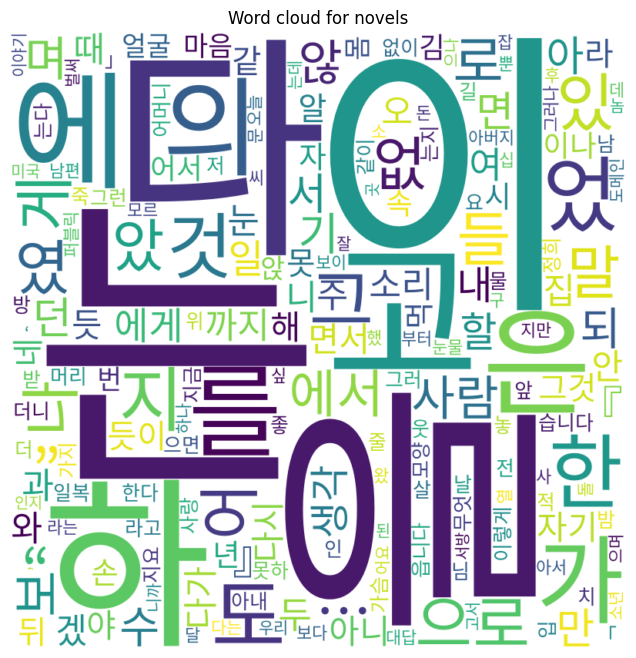

In [22]:
create_word_cloud(novels_word_frequency, "Word cloud for novels")


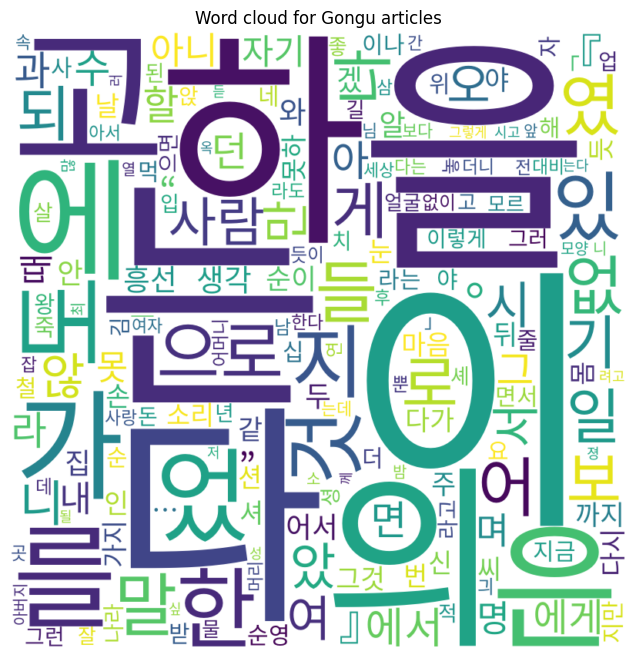

In [23]:
create_word_cloud(articles_word_frequency, "Word cloud for Gongu articles")

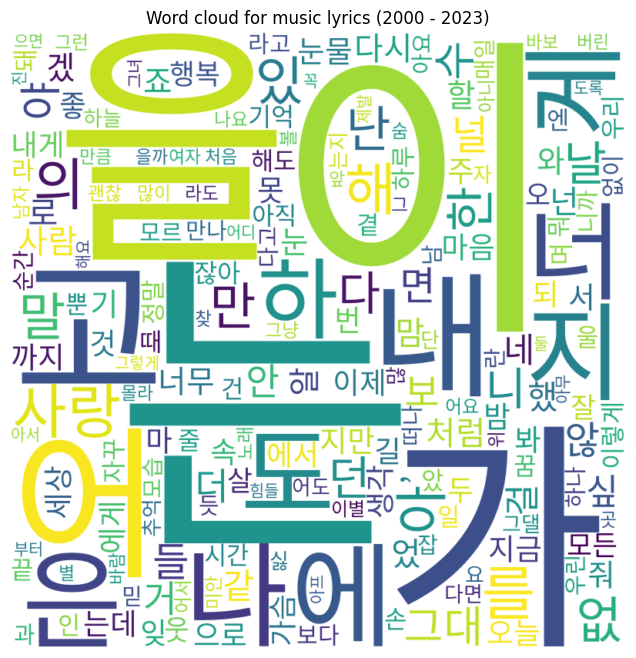

In [24]:
create_word_cloud(lyrics_word_frequency, "Word cloud for music lyrics (2000 - 2023)")

In [25]:
logging.info("##### WORD CLOUD FOR SOME POS #####")
pos_list = ["NNG", "VA", "VV", "MAG"]

INFO:root:##### WORD CLOUD FOR SOME POS #####


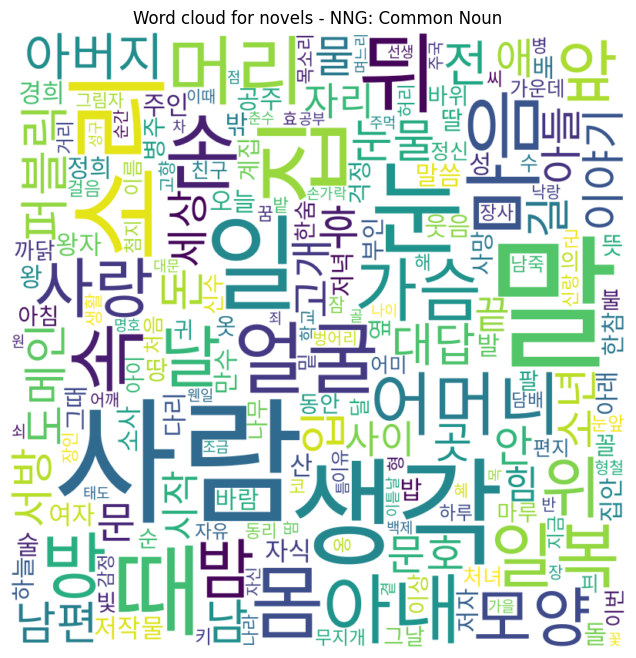

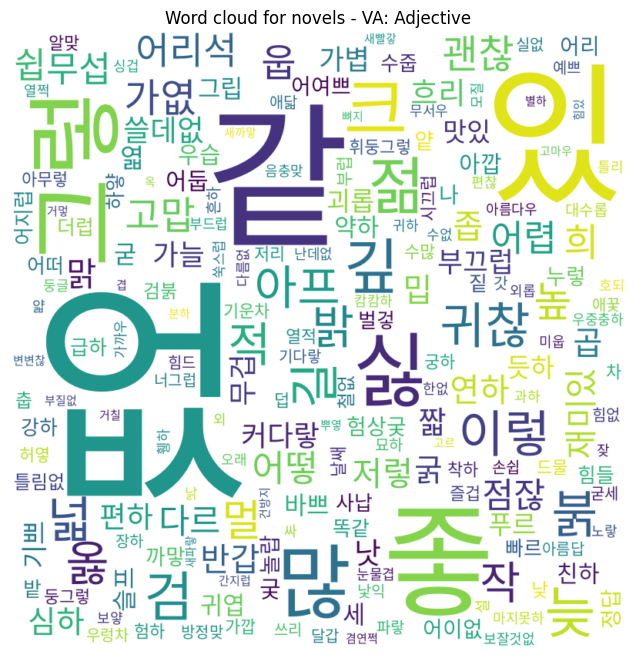

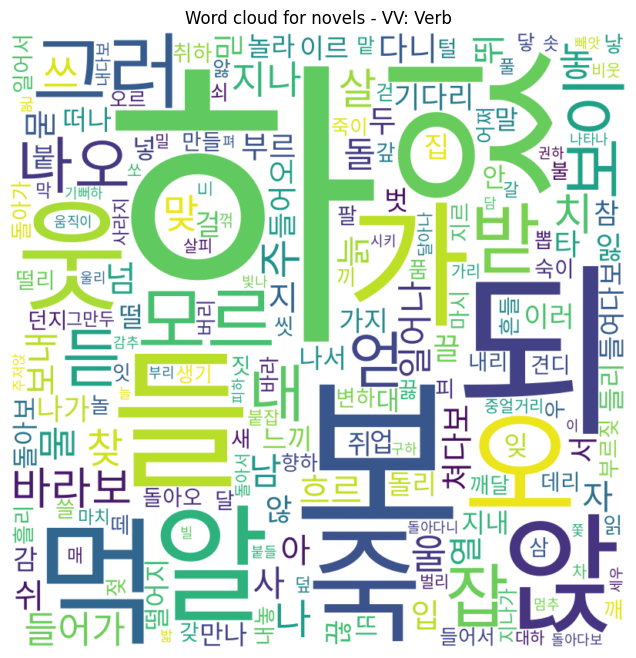

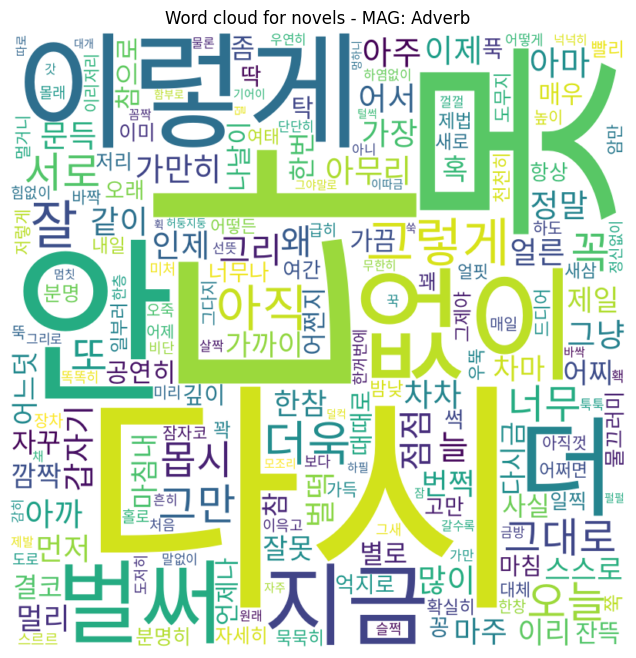

In [26]:
for pos in pos_list:
    df_temp_ = pd.DataFrame(columns=["word", "abs_freq"])
    for novel in novels:
        current_frequency = get_word_frequency(novel["content"], pos)
        if df_temp_.empty:
            df_temp_ = current_frequency.copy()
        else:
            df_temp_ = pd.concat([df_temp_, current_frequency])
            df_temp_ = df_temp_.groupby(["word"], as_index=False)["abs_freq"].sum().sort_values("abs_freq", ascending=False).reset_index(drop=True)
    create_word_cloud(df_temp_, f"Word cloud for novels - {pos}: {mecab_pos[pos]}")

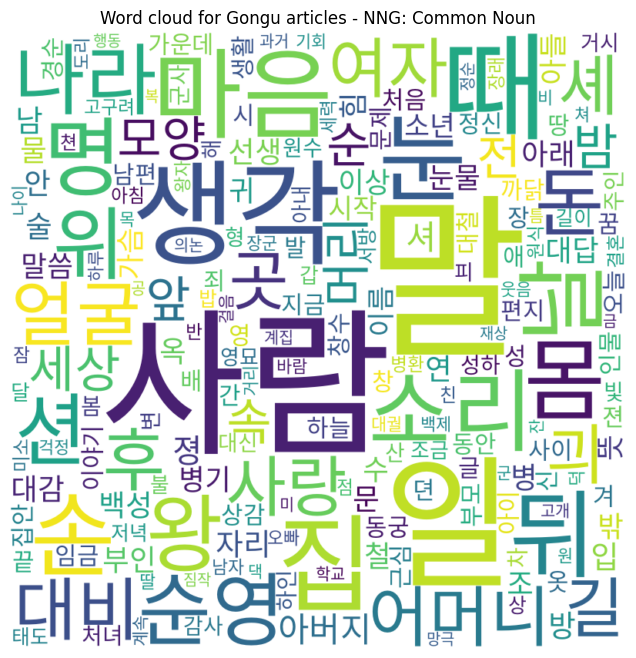

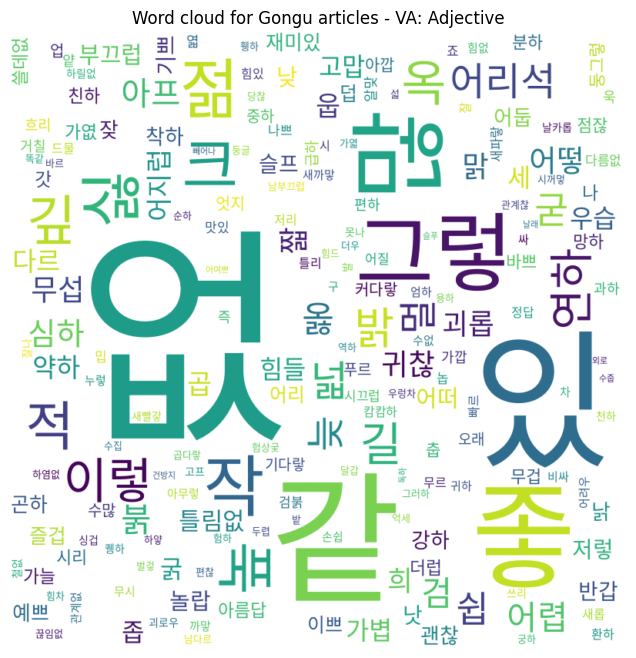

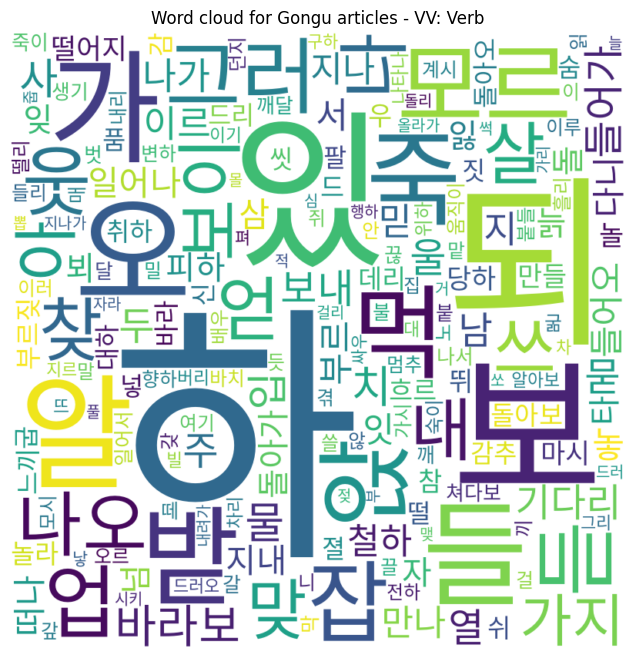

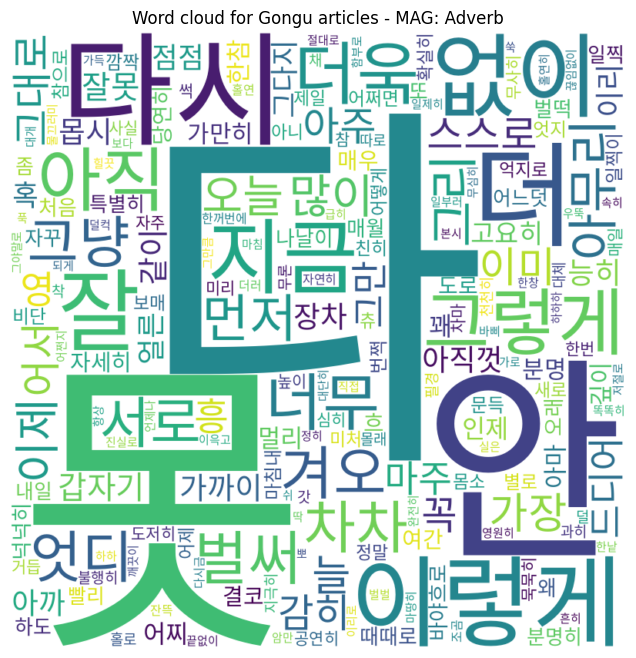

In [27]:
for pos in pos_list:
    df_temp_ = get_word_frequency(gongu, pos)
    create_word_cloud(df_temp_, f"Word cloud for Gongu articles - {pos}: {mecab_pos[pos]}")

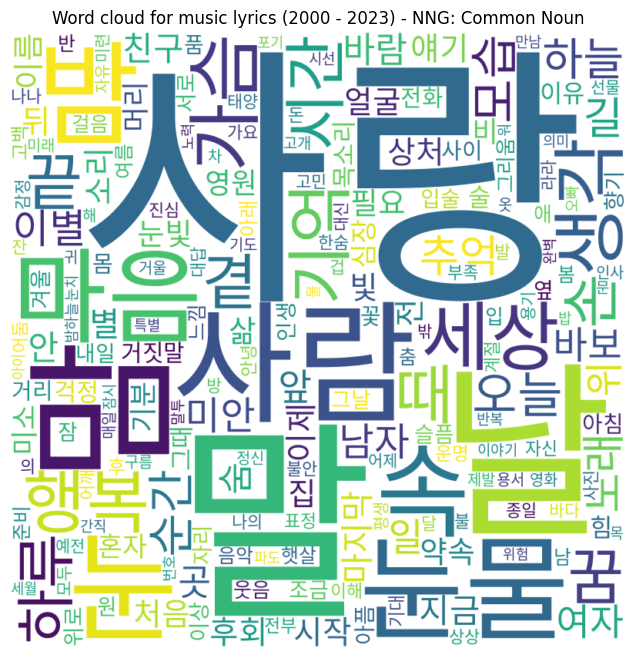

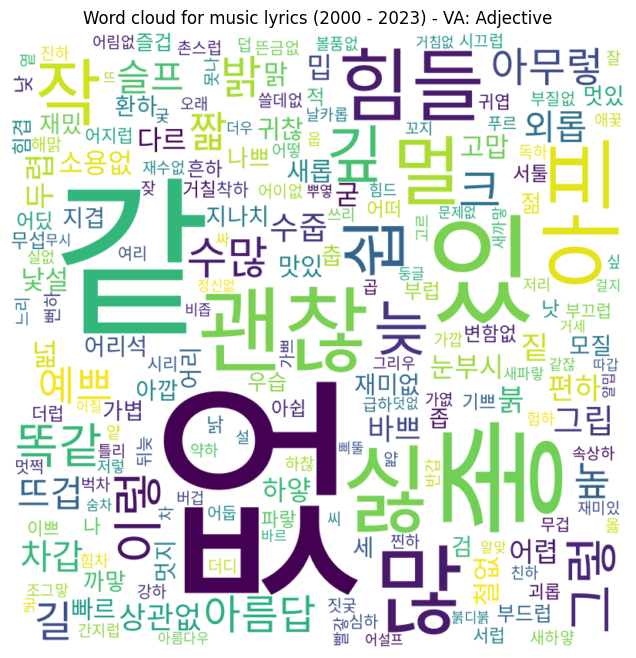

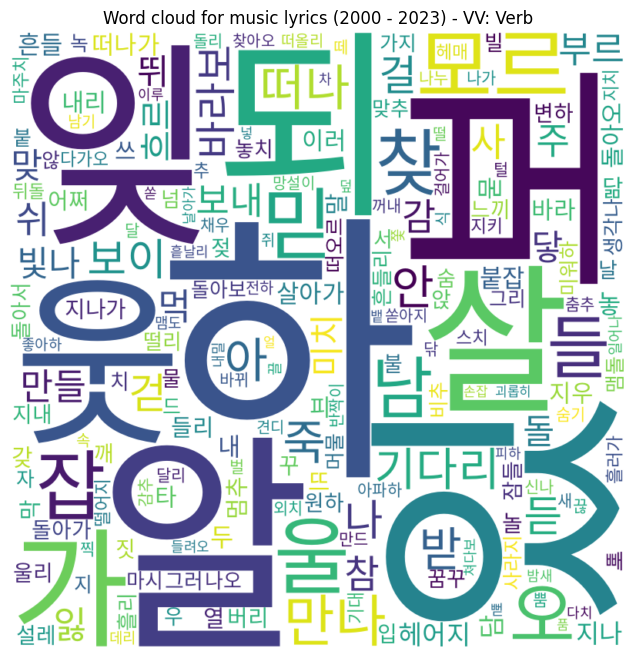

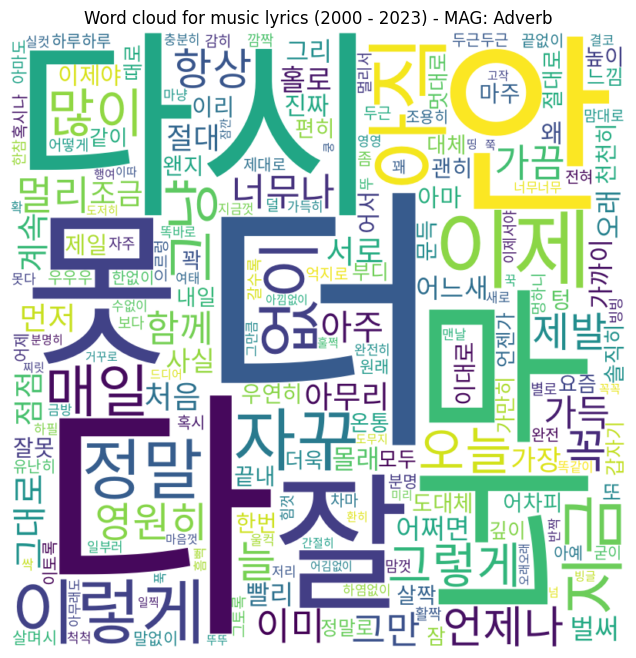

In [28]:
for pos in pos_list:
    df_temp_ = get_word_frequency(lyrics, pos)
    create_word_cloud(df_temp_, f"Word cloud for music lyrics (2000 - 2023) - {pos}: {mecab_pos[pos]}")

In [29]:
def count_words(text):
    total = 0
    for line in text:
        total += len(mecab.morphs(line))
    return total

In [30]:
def count_words_by_pos(text):
    word_dict = defaultdict(int)
    for line in text:
        for word in mecab.pos(line):
                word_dict[word[1]] += 1
    return word_dict

In [31]:
def compute_percent_word(df, total):
    new_df = df.copy()
    for index, row in new_df.iterrows():
        new_df.loc[index, 'percent']  = row["abs_freq"] / total * 100
    return new_df

In [32]:
def compute_number_words_for_percent(df, percent):
    count_words = 0
    count_percent = 0
    if df.loc[0]["percent"] > percent:
        return 1
    for _, row in df.iterrows():
        if count_percent + row["percent"] <= percent:
            count_percent += row["percent"]
            count_words += 1
        else:
            break
    return count_words

In [33]:
logging.info("##### CONFIRMING LONG TAIL PHENOMENA #####")
novels_numbers_words = 0
novels_number_words_pos = {}
i = 0
for novel in novels:
    novels_numbers_words += count_words(novel["content"])
    novels_number_words_pos = Counter(novels_number_words_pos) + Counter(count_words_by_pos(novel["content"]))
gongu_number_words = count_words(gongu)
lyrics_number_words = count_words(lyrics)
gongu_number_words_pos = count_words_by_pos(gongu)
lyrics_number_words_pos = count_words_by_pos(lyrics)

INFO:root:##### CONFIRMING LONG TAIL PHENOMENA #####


In [34]:
percent_words_frequency_novels = compute_percent_word(novels_word_frequency, novels_numbers_words)
percent_words_frequency_gongu = compute_percent_word(articles_word_frequency, gongu_number_words)
percent_words_frequency_lyrics = compute_percent_word(lyrics_word_frequency, lyrics_number_words)

In [35]:
percent_list = [10, 20, 50, 80, 90, 95, 99, 99.5]

In [36]:
print(f"Total number of words: {novels_numbers_words: ,}.")
print(f"Number of unique words: {len(novels_word_frequency): ,}.")
for percent in percent_list: 
    print (f"{compute_number_words_for_percent(percent_words_frequency_novels, percent):,} words represent {percent}% of the total words seen.")

Total number of words:  325,959.
Number of unique words:  19,778.
2 words represent 10% of the total words seen.
6 words represent 20% of the total words seen.
67 words represent 50% of the total words seen.
1,075 words represent 80% of the total words seen.
3,510 words represent 90% of the total words seen.
7,350 words represent 95% of the total words seen.
16,518 words represent 99% of the total words seen.
18,148 words represent 99.5% of the total words seen.


In [37]:
print(f"Total number of words: {gongu_number_words: ,}.")
print(f"Number of unique words: {len(articles_word_frequency): ,}.")
for percent in percent_list: 
    print (f"{compute_number_words_for_percent(percent_words_frequency_gongu, percent):,} words represent {percent}% of the total words seen.")

Total number of words:  628,104.
Number of unique words:  32,389.
3 words represent 10% of the total words seen.
7 words represent 20% of the total words seen.
80 words represent 50% of the total words seen.
1,326 words represent 80% of the total words seen.
4,513 words represent 90% of the total words seen.
10,080 words represent 95% of the total words seen.
26,107 words represent 99% of the total words seen.
29,248 words represent 99.5% of the total words seen.


In [38]:
print(f"Total number of words: {lyrics_number_words: ,}.")
print(f"Number of unique words: {len(lyrics_word_frequency): ,}.")
for percent in percent_list: 
    print (f"{compute_number_words_for_percent(percent_words_frequency_lyrics, percent):,} words represent {percent}% of the total words seen.")

Total number of words:  6,383,870.
Number of unique words:  25,963.
5 words represent 10% of the total words seen.
11 words represent 20% of the total words seen.
65 words represent 50% of the total words seen.
533 words represent 80% of the total words seen.
1,565 words represent 90% of the total words seen.
3,489 words represent 95% of the total words seen.
11,059 words represent 99% of the total words seen.
14,743 words represent 99.5% of the total words seen.


In [39]:
logging.info("##### DATA FOR SOME POS - Novels #####")
for pos in pos_list:
    frequency_ = pd.DataFrame(columns=["word", "abs_freq"])
    for novel in novels:
        current_frequency = get_word_frequency(novel["content"], pos)
        if frequency_.empty:
            frequency_ = current_frequency.copy()
        else:
            frequency_ = pd.concat([frequency_, current_frequency])
            frequency_ = frequency_.groupby(["word"], as_index=False)["abs_freq"].sum().sort_values("abs_freq", ascending=False).reset_index(drop=True)
            
    number_words_ = compute_percent_word(frequency_, novels_number_words_pos[pos])
    print(f"Total number of {mecab_pos[pos]}s seen: {novels_number_words_pos[pos]: ,}.")
    print(f"Number of unique words: {len(number_words_): ,}.")
    for percent in percent_list: 
        temp_ = compute_number_words_for_percent(number_words_, percent)
        print (f"{temp_:,} {mecab_pos[pos]}s represent {percent}% of the total {mecab_pos[pos]}s seen.")
    print("##########")

INFO:root:##### DATA FOR SOME POS - Novels #####


Total number of Common Nouns seen:  69,484.
Number of unique words:  9,796.
8 Common Nouns represent 10% of the total Common Nouns seen.
30 Common Nouns represent 20% of the total Common Nouns seen.
280 Common Nouns represent 50% of the total Common Nouns seen.
1,897 Common Nouns represent 80% of the total Common Nouns seen.
4,018 Common Nouns represent 90% of the total Common Nouns seen.
6,321 Common Nouns represent 95% of the total Common Nouns seen.
9,101 Common Nouns represent 99% of the total Common Nouns seen.
9,448 Common Nouns represent 99.5% of the total Common Nouns seen.
##########
Total number of Adjectives seen:  5,745.
Number of unique words:  399.
1 Adjectives represent 10% of the total Adjectives seen.
1 Adjectives represent 20% of the total Adjectives seen.
3 Adjectives represent 50% of the total Adjectives seen.
43 Adjectives represent 80% of the total Adjectives seen.
106 Adjectives represent 90% of the total Adjectives seen.
184 Adjectives represent 95% of the total

In [40]:
logging.info("##### DATA FOR SOME POS - Gongu articles #####")
for pos in pos_list:
    frequency_ = get_word_frequency(gongu, pos)
    number_words_ = compute_percent_word(frequency_, gongu_number_words_pos[pos])
    print(f"Total number of {mecab_pos[pos]}s seen: {gongu_number_words_pos[pos]: ,}.")
    print(f"Number of unique words: {len(number_words_): ,}.")
    for percent in percent_list: 
        temp_ = compute_number_words_for_percent(number_words_, percent)
        print (f"{temp_:,} {mecab_pos[pos]}s represent {percent}% of the total {mecab_pos[pos]}s seen.")
    print("##########")

INFO:root:##### DATA FOR SOME POS - Gongu articles #####


Total number of Common Nouns seen:  142,959.
Number of unique words:  16,000.
8 Common Nouns represent 10% of the total Common Nouns seen.
35 Common Nouns represent 20% of the total Common Nouns seen.
394 Common Nouns represent 50% of the total Common Nouns seen.
2,682 Common Nouns represent 80% of the total Common Nouns seen.
5,689 Common Nouns represent 90% of the total Common Nouns seen.
8,911 Common Nouns represent 95% of the total Common Nouns seen.
14,570 Common Nouns represent 99% of the total Common Nouns seen.
15,285 Common Nouns represent 99.5% of the total Common Nouns seen.
##########
Total number of Adjectives seen:  10,331.
Number of unique words:  447.
1 Adjectives represent 10% of the total Adjectives seen.
1 Adjectives represent 20% of the total Adjectives seen.
3 Adjectives represent 50% of the total Adjectives seen.
35 Adjectives represent 80% of the total Adjectives seen.
88 Adjectives represent 90% of the total Adjectives seen.
158 Adjectives represent 95% of the t

In [ ]:
logging.info("##### DATA FOR SOME POS - Music lyrics #####")
for pos in pos_list:
    frequency_ = get_word_frequency(lyrics, pos)
    number_words_ = compute_percent_word(frequency_, lyrics_number_words_pos[pos])
    print(f"Total number of {mecab_pos[pos]}s seen: {lyrics_number_words_pos[pos]: ,}.")
    print(f"Number of unique words: {len(number_words_): ,}.")
    for percent in percent_list: 
        temp = compute_number_words_for_percent(number_words_, percent)
        print (f"{temp:,} {mecab_pos[pos]}s represent {percent}% of the total {mecab_pos[pos]}s seen.")
    print("##########")

INFO:root:##### DATA FOR SOME POS - Music lyrics #####


Total number of Common Nouns seen:  1,131,418.
Number of unique words:  11,067.
1 Common Nouns represent 10% of the total Common Nouns seen.
7 Common Nouns represent 20% of the total Common Nouns seen.
61 Common Nouns represent 50% of the total Common Nouns seen.
453 Common Nouns represent 80% of the total Common Nouns seen.
1,270 Common Nouns represent 90% of the total Common Nouns seen.
2,618 Common Nouns represent 95% of the total Common Nouns seen.
6,493 Common Nouns represent 99% of the total Common Nouns seen.
7,885 Common Nouns represent 99.5% of the total Common Nouns seen.
##########
Total number of Adjectives seen:  188,196.
Number of unique words:  494.
1 Adjectives represent 10% of the total Adjectives seen.
1 Adjectives represent 20% of the total Adjectives seen.
3 Adjectives represent 50% of the total Adjectives seen.
21 Adjectives represent 80% of the total Adjectives seen.
52 Adjectives represent 90% of the total Adjectives seen.
92 Adjectives represent 95% of the total

In [ ]:
percent_words_frequency_index_start_at_1_novels = percent_words_frequency_novels.copy()
percent_words_frequency_index_start_at_1_novels.index += 1
ax = percent_words_frequency_index_start_at_1_novels.plot(use_index=True, y="abs_freq", title="Word frequency versus rank - Novels", xlim=(0,200), legend=False)
ax.set_xlabel("Rank")
ax.set_ylabel("Frequency")

In [ ]:
percent_words_frequency_index_start_at_1_gongu = percent_words_frequency_gongu.copy()
percent_words_frequency_index_start_at_1_gongu.index += 1
ax = percent_words_frequency_index_start_at_1_gongu.plot(use_index=True, y="abs_freq", title="Word frequency versus rank - Gongu articles", xlim=(0,200), legend=False)
ax.set_xlabel("Rank")
ax.set_ylabel("Frequency")

In [ ]:
percent_words_frequency_index_start_at_1_lyrics = percent_words_frequency_lyrics.copy()
percent_words_frequency_index_start_at_1_lyrics.index += 1
ax = percent_words_frequency_index_start_at_1_lyrics.plot(use_index=True, y="abs_freq", title="Word frequency versus rank - Music lyrics", xlim=(0,200), legend=False)
ax.set_xlabel("Rank")
ax.set_ylabel("Frequency")